In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import *

# Sklearn imports
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.datasets import load_diabetes, fetch_california_housing
from sklearn.linear_model import LogisticRegressionCV

#import imodels
from imodels.tree.rf_plus.feature_importance.ppms.ppms import MDIPlusGenericRegressorPPM, MDIPlusGenericClassifierPPM
from imodels.tree.rf_plus.feature_importance.ppms.ppms import AloMDIPlusPartialPredictionModelRegressor, AloMDIPlusPartialPredictionModelClassifier
from imodels.tree.rf_plus.rf_plus_prediction_models.aloocv_regression import AloGLMRegressor, AloElasticNetRegressorCV
from imodels.tree.rf_plus.rf_plus_prediction_models.aloocv_classification import AloGLMClassifier, AloLogisticElasticNetClassifierCV
from imodels.tree.rf_plus.data_transformations.block_transformers import BlockTransformerBase, _blocked_train_test_split, BlockPartitionedData
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor, RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI, RFPlusMDI


# # Group 3: 10 features, 250 samples, second feature has mean 1
# group_3 = np.random.normal(0, 1, (250, 10))
# #group_3[:, 1] += 1

# # Group 4: 10 features, 250 samples, first and second features have mean 1
# group_4 = np.random.normal(0, 1, (250, 10))
# group_4[:, 0] = 0
# #group_4[:, 1] += 1

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Simulate data from four groups
np.random.seed(42)  # For reproducibility
group_size = 500
train_group_size = int(0.8*group_size)
test_group_size = int(0.2*group_size)
# Group 1: Standard Gaussian with 10 features, 250 samples
X_group_1 = np.random.normal(0, 1, (group_size, 10))
beta_group1 = np.array([10,0,0,0,0,0,0,0,0,0])
y_group1 = np.dot(X_group_1, beta_group1) + np.random.normal(0, 0.1, group_size)

# Group 2: 10 features, 250 samples, first feature has mean 1
X_group_2 = np.random.normal(0, 1, (group_size, 10))
beta_group2 = np.array([0,10,0,0,0,0,0,0,0,0])
y_group2 = np.dot(X_group_2, beta_group2) + np.random.normal(0, 0.1, group_size)
#group_2[:, 0] += 1

# Combine all groups into a single dataset
# X = np.vstack((group_1, group_2))
# y = np.hstack((y_group1, y_group2))


X_train = np.vstack((X_group_1[:train_group_size,:], X_group_2[:train_group_size,:]))
y_train = np.hstack((y_group1[:train_group_size], y_group2[:train_group_size]))


X_test = np.vstack((X_group_1[test_group_size:,:], X_group_2[test_group_size:,:]))
y_test = np.hstack((y_group1[test_group_size:], y_group2[test_group_size:]))



In [3]:
# train test split
#fit RF+ model
rf_plus = RandomForestPlusRegressor(include_raw=False)
rf_plus.fit(X_train, y_train)

#predict
y_pred = rf_plus.predict(X_test)
r2_score(y_test, y_pred)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/__init__.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.

0.6050344515286523

In [4]:
mdi_explainer = AloRFPlusMDI(rf_plus,evaluate_on='oob')
mdi, partial_preds = mdi_explainer.explain(X_train[:], y_train[:])
mdi_rankings = mdi_explainer.get_rankings(mdi)



In [5]:
group1_mdi, group2_mdi = mdi[:train_group_size], mdi[train_group_size:]
group1_rank, group2_rank = mdi_rankings[:train_group_size], mdi_rankings[train_group_size:]
group1_av_mdi, group2_av_mdi = np.mean(mdi[:train_group_size],axis = 0), np.mean(mdi[train_group_size:],axis = 0)
group1_av_rank, group2_av_rank = np.mean(mdi_rankings[:train_group_size],axis = 0), np.mean(mdi_rankings[train_group_size:],axis = 0)
group2_av_rank = np.mean(mdi_rankings[train_group_size:],axis = 0)
group1_av_rank, group2_av_rank


(array([1.2925, 4.0175, 5.23  , 5.675 , 5.535 , 5.4725, 5.2025, 4.95  ,
        4.74  , 2.885 ]),
 array([1.925 , 3.8025, 5.475 , 5.275 , 5.3575, 5.4075, 5.445 , 5.54  ,
        4.685 , 2.0875]))

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


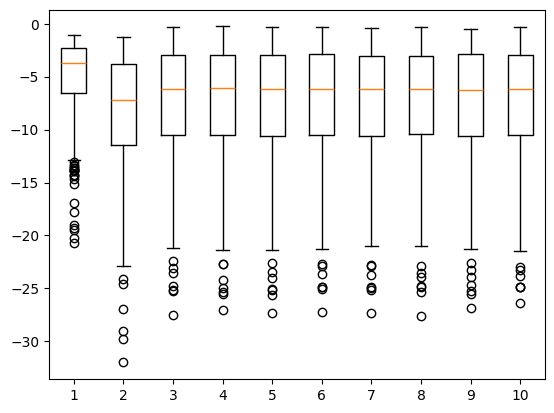

In [6]:
plt.boxplot(group1_mdi)
plt.show()

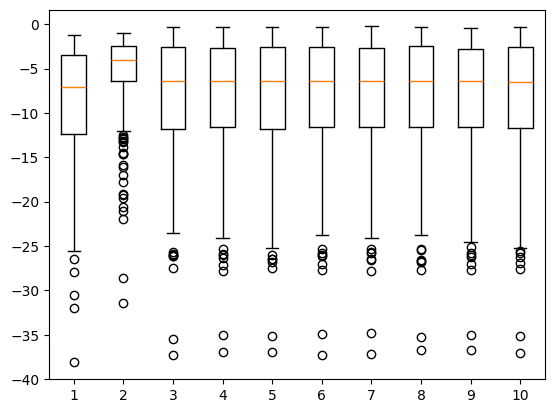

In [7]:
plt.boxplot(group2_mdi)
plt.show()

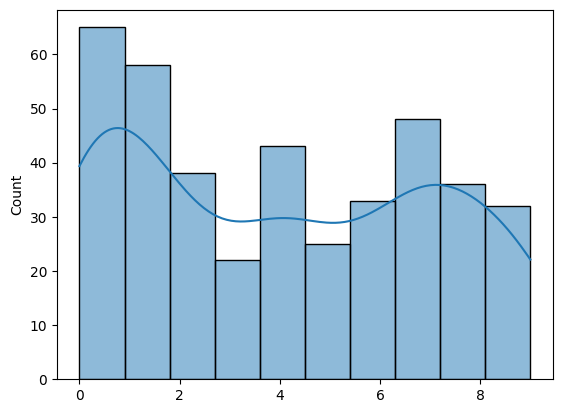

In [15]:
sns.histplot(group1_rank[:, 1], kde = True)
plt.show()

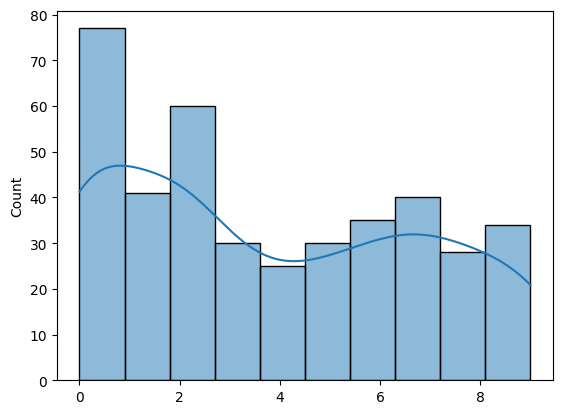

In [14]:
sns.histplot(group2_rank[:, 1], kde = True)
plt.show()

In [8]:
rbomat = rbo_matrix(mdi_rankings, 0.9)

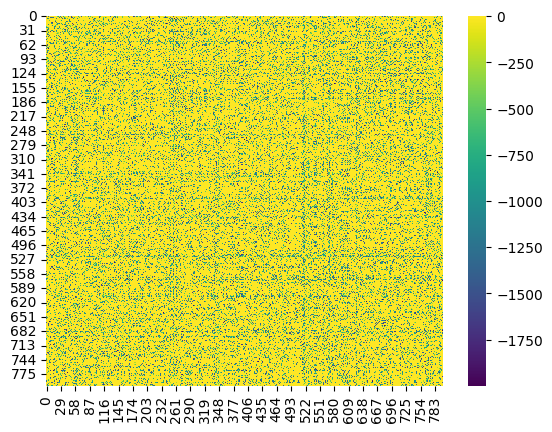

In [9]:
sns.heatmap(rbomat, cmap='viridis')

# Display the heatmap
plt.show()